# Introduction

This document provides an overview of existing food accessibility measures and presents a new method to quantify food accessibility through delivery service. Food accessibility is a critical issue, especially in urban areas where access to fresh and healthy food is limited. Existing measures of food accessibility are often based on the distance to the nearest grocery store or supermarket. However, these measures do not take into account the availability of delivery services, which can significantly improve food accessibility for people who cannot easily access physical stores. 

Data Source: 
1. Food establishments in Seattle from King County Food Inspection Data. Due to runtime concerns, the food establishments data is sampled from 5000+ down to only 400. So the results in this jupyter notebook does not reflect the food accessibility status in Seattle.
1. Tracts (csv and shapefiles) in Seattle from King County GIS Open Data.

In [30]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [81]:
import shapely
import shapely.wkt
from shapely.geometry import Point
import matplotlib.patches as patches
from shapely.geometry.polygon import Polygon
import math
import ast
from haversine import haversine

In [3]:
# read Seattle_FB_sampled.csv
df_poi = pd.read_csv('Seattle_FB_sampled.csv')
# read Seattle_Tracts.csv
df_tracts = pd.read_csv('Seattle_Tracts.csv')


In [5]:
df_poi.columns

Index(['Unnamed: 0', 'lon', 'lat', 'OBJECTID', 'FEATURE_ID', 'ESITE', 'CODE',
       'NAME', 'ABB_NAME', 'ADDRESS', 'ZIPCODE', 'CITY', 'PHONE', 'SEAT_CAP',
       'RISK', 'main_type', 'capacity', 'price', 'RECORD_ID', 'FACILITY_NAME',
       'CHAIN_NAME', 'CHAIN_ESTABLISHMENT', 'SITE_ADDRESS'],
      dtype='object')

In [12]:
df_tracts.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'OBJECTID', 'TRACT', 'TRACTCE10',
       'GEOID10', 'NAME10', 'NAMELSAD10', 'ACRES_TOTA', 'WATER', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry', 'CensusTract', 'Pop2010', 'hh_snap_rate',
       'MedianFamilyIncome', 'LowIncomeTracts', 'LA1and10',
       'LATractsVehicle_20', 'centroid', 'ycoord', 'xcoord'],
      dtype='object')

## Existing food accessibility metrics
Intuitively, we can think of food accessibility as the extent of potential opportunities of obtaining food. The quantification of "extent" can come in different forms. For example, if one gets to a restaurant quicker, or travels less distance, or spends less money, then the food accessibility is higher, just to name a few. It is also accepted that food accessibility is higher if there are more food establishments located in a predefined area (a placed based accessibility measure).

### The first metric
The distance to the nearest food establishment from a census tract's centroid. This metric is simple and straightforward. It can also be converted to travel time if we know the mode choice, as well as the cost of travel through value of time. 

In [ ]:
# define a function to calculate the distance between two points in miles
def calc_distance(row):
    tract_lat, tract_lon = row['ycoord'], row['xcoord']
    poi_lat, poi_lon = df_poi.loc[df_poi.apply(lambda x: geodesic((tract_lat, tract_lon), (x['lat'], x['lon'])).miles, axis=1).idxmin(), ['lat', 'lon']]
    return geodesic((tract_lat, tract_lon), (poi_lat, poi_lon)).miles

# calculate the distance of each tract's centroid to the closest POI in miles
df_tracts['distance_to_closest_poi'] = df_tracts.apply(calc_distance, axis=1)



In [15]:
df_tracts['distance_to_closest_poi'].describe()

count    135.000000
mean       0.371157
std        0.264309
min        0.015894
25%        0.181913
50%        0.333710
75%        0.534817
max        1.394890
Name: distance_to_closest_poi, dtype: float64

|Pros|Cons|
|---|---|
|Simple and straightforward|?|
|Provides a clear, numerical value that can be used for comparison|?|
|?|?|

### The second metric: Cumulative Opportunities
The number of food establishments within a predefined distance from a census tract's centroid. This metrics essentially draws a circle around the census tract's centroid and counts the number of food establishments within the circle. Based on the size of the circle, we can get different counts.

In [20]:
# Function to calculate geodesic distance between two points using geopy
def geodesic_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Prespecified distance
prespecified_distance = 5.0  # Replace with your desired distance in kilometers

# Function to count establishments within prespecified distance
def count_establishments(row):
    tract_coord = (row['ycoord'], row['xcoord'])
    establishments_within_distance = df_poi.apply(lambda x: geodesic_distance(tract_coord, (x['lat'], x['lon'])), axis=1)
    return len(establishments_within_distance[establishments_within_distance <= prespecified_distance])

# Apply the function to create a new column in df_tracts
df_tracts['Cumu_opp'] = df_tracts.apply(count_establishments, axis=1)



In [21]:
df_tracts['Cumu_opp'].describe()

count    135.000000
mean     110.666667
std       69.619113
min       14.000000
25%       51.000000
50%       92.000000
75%      184.500000
max      240.000000
Name: Cumu_opp, dtype: float64

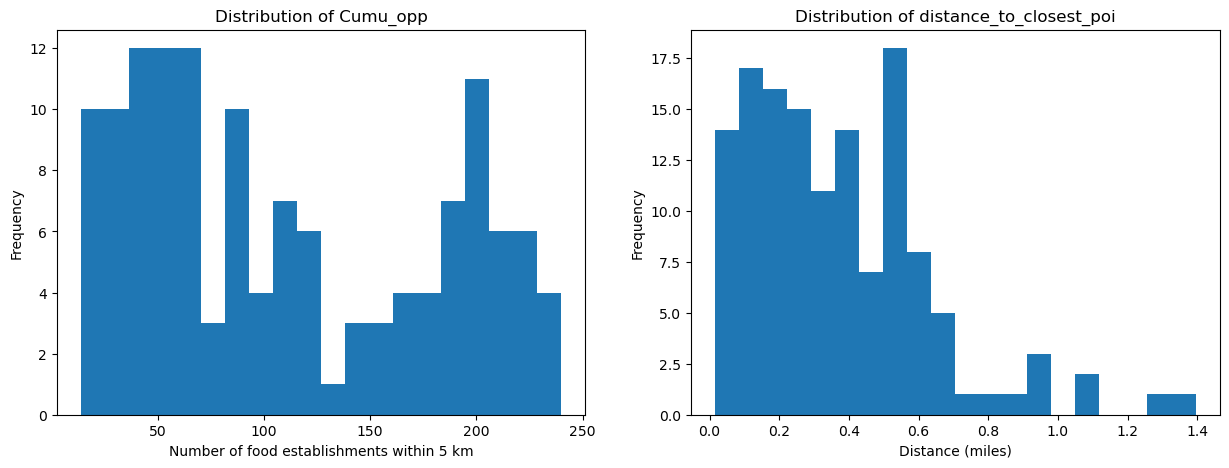

In [29]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the histogram of Cumu_opp column on the first subplot
ax1.hist(df_tracts['Cumu_opp'], bins=20)
ax1.set_title('Distribution of Cumu_opp')
ax1.set_xlabel('Number of food establishments within 5 km')
ax1.set_ylabel('Frequency')

# plot the histogram of distance_to_closest_poi column on the second subplot
ax2.hist(df_tracts['distance_to_closest_poi'], bins=20)
ax2.set_title('Distribution of distance_to_closest_poi')
ax2.set_xlabel('Distance (miles)')
ax2.set_ylabel('Frequency')

# display the figure
plt.show()


|Pros|Cons|
|---|---|
|provides a sense of possible opportinities in an area|?|
|also numerical value|?|
|?|?|

### The third metric: gravity-based accessibility
The gravity-based accessibility metric is a measure of accessibility that takes into account both the distance between a location and a set of destinations, as well as the attractiveness of those destinations. It is based on the idea that the probability of a person visiting a destination decreases with distance. The metric is calculated by summing the accessibility scores of all destinations within a certain radius of a location, where the accessibility score of each destination is calculated using a gravity model that takes into account the distanceof the destination. The resulting score provides a measure of the overall accessibility of the location to the set of destinations.

Key feature: distance decay function such as negative exponential, power, or Gaussian.

Gaussian functional form:
 
$f(d_{ij}) = exp(-d_{ij}^2/\beta)$, where i is the centroid of a census tract, j is the location of a food establishment, and $\beta$ is a parameter that controls the rate of decay. Since Gaussian function connverges to 0, $\beta$ can be derived at the critical value of f(d) = 0.01, which is $\beta = -d^2/ln(0.01)$. Further, the U.S. Department of Agriculture Food Access Research Atlas designates the maximum travel distance for food purchase as 20 miles, we can calibrate $\beta$ to be 86.9.

In [36]:
prespecified_distance = 5.0  # Replace with your desired distance in kilometers
decay_parameter = 86.9  # Adjust as needed

# Function to calculate gravity-based accessibility metric with distance decay
def calculate_accessibility(row):
    tract_coord = (row['ycoord'], row['xcoord'])
    distances = df_poi.apply(lambda x: geodesic_distance(tract_coord, (x['lat'], x['lon'])), axis=1)
    accessibility_values = np.exp(-distances**2 / decay_parameter)
    return accessibility_values.sum()

# Apply the function to create a new column in df_tracts
df_tracts['gravity_acc'] = df_tracts.apply(calculate_accessibility, axis=1)



In [37]:
df_tracts[['distance_to_closest_poi','Cumu_opp','gravity_acc']].describe()

,distance_to_closest_poi,Cumu_opp,gravity_acc
count,135.000000,135.000000,135.000000
mean,0.371157,110.666667,200.349810
std,0.264309,69.619113,60.281012
min,0.015894,14.000000,63.324805
25%,0.181913,51.000000,148.684250
50%,0.333710,92.000000,197.028437
75%,0.534817,184.500000,255.143077
max,1.394890,240.000000,287.078429


### The fourth metric: utility-based metrics
The utility in this context typically refers to the value or benefit that a destination provides. For example, the utility can depend on the the store size, the variety of products it offers, its prices, its quality of service, operational hours, etc. It is based on the idea that people are more likely to visit destinations that are more valuable or useful to them, even if they are farther away. 

To calculate utility-based accessibility, we need data on the quality of the food or products sold at each destination, or other factors that might influence people's decisions about where to go. We might also need to normalize or weight these factors to make them comparable. The coefficients in the utility function are typically estimated using a discrete choice model, such as a multinomial logit model. Customers' probabilities to visit the food establishments follow the random utility maximiztion principle. 

In [ ]:
# code omitted due to no related data available

### Question time
1. What are the common themes of these metrics?
1. What are the things that are missing from these metrics?


## The New Metric: a modified 2-step floating catchment area (2SFCA) method
The 2SFCA method is a spatial accessibility measure that was originally developed for assessing healthcare accessibility, but it can also be applied to food accessibility.

The method involves two steps:

1. **Supply-to-demand Ratio:** For each food establishment (e.g., grocery store), a catchment area is defined based on a certain travel time or distance. All residential areas within this catchment are considered to have access to this establishment. The supply-to-demand ratio for a food establishment is calculated as the total supply (e.g., size of the store, number of products) divided by the total demand (e.g., population) within its catchment area.

2. **Accessibility Calculation:** The accessibility of each residential area is then calculated as the sum of the "supply-to-demand ratios" of all food establishments within its catchment area. 

The 2SFCA method takes into account both the supply side (availability of food establishments and their capacity) and the demand side (population density and competition for resources).

#### what about ...
- competition between food establishments?
- complementary effects between food establishments?
- delivery service?


### The math behind our modified 2SFCA:
1. Supply-to-demand ratio: $R_j = \frac{\text{cap}_j}{\sum_{i\in{d_{ij}\le r}}{P_i\times p\left(c_{ij}\right)}}$
    - $p\left(c_{ij}\right)=\ \frac{e^{-\beta c_{ij}}}{\sum_{q\in\left\{d_{iq}\le r\right\}} e^{-\beta c_{iq}}}$
    - $c_{ij}$ is a generalized cost function for residents in tract i to patronize establishment j
1. Category specific food accessibility: $A_{ic}=\sum_{j\in\left\{d_{ij}\le r,\ C_j=c\right\}}{R_{j\ }\times}p\left(c_{ij}\right)$
1. Food accessibility: $A_i=\ \sum_{c=1}^{C}A_{ic}$
    - C is the number of food categories
2. Diversity Index of food accessibility: $D_i = \ - \sum_{c=1}^{C}\frac{A_{ic}}{A_{i}}\ \times\ln{\left(\frac{A_{ic}}{A_i}\right)}$

In [40]:
df_tracts.to_csv('Seattle_Tracts_preprocessed.csv', index=False)

In [55]:
class Accessibility_Seattle():
    def __init__(self,space_conv = 0.003, vot = 0.72, 
                 t_threshold = 15, 
                 FCA_pop_min = 0.05, 
                 delivery = 5,
                 beta = 86.9):
        self.beta = beta
        self.space_conv = space_conv
        self.sqm2sqft = 10.76
        self.delivery_distance = delivery
        self.delivery_start_distance = 1.5
        self.vot = vot
        self.radii = {}
        self.dist_dict = {}
        self.cost_dict = {}
        self.time_dict = {}
        self.poi_dict_AWOD = {}
        self.pop_dict_AWOD = {}
        self.poi_dict_AWDO = {}
        self.pop_dict_AWDO = {}
        self.poi_cap = {}
        self.pop2poi_AWOD = {}
        self.pop2poi_AWDO = {}
        self.R_j_AWOD = {}
        self.R_j_AWDO = {}
        self.pop_acc_AWOD = {}
        self.pop_acc_AWDO = {}
        self.pop_acc_AWD = {}
        self.food_cost = {}
        self.acc_AWOD = {}
        self.acc_AWD = {}
        self.acc_AWDO = {}
        self.div_index_AWOD = {}
        self.div_index_AWD = {}
        self.div_index_AWDO = {}
    
        self.walk_speed = 5
        self.drive_speed =40 #km/h
        self.t = t_threshold
        self.FCA_pop_min = FCA_pop_min
        
        self.D_j_AWOD = {}
        self.D_j_AWDO = {}
    
    def readPOI(self, path):
        self.POI = pd.read_csv(path)
        for j in range(0,len(self.POI)):
            self.R_j_AWOD[j] = None
            self.R_j_AWDO[j] = None
            self.food_cost[j] = None
            self.D_j_AWOD[j] = None
            self.D_j_AWDO[j] = None
            self.pop_dict_AWOD[j] = []
            self.pop_dict_AWDO[j] = []
                   
        poi_types = set(self.POI["main_type"])
        self.poi_types = poi_types
        
        self.type_index = {} 
        for c in self.poi_types:
            self.type_index[c] = []
            if c == "restaurant":
                self.radii[c] = 6.1 
            elif c == "grocery":
                self.radii[c] = 4.67 
            else:
                self.radii[c] = 4.96 
            
            for j in range(0,len(self.POI)):
                if self.POI["main_type"][j] == c:
                    self.type_index[c].append(j)
        
    def readPOP(self,path, UD = False):
        self.pop = pd.read_csv(path)
        self.tract_names  = {}
        self.tract_names_IP = {}
        
        for i in range(0, len(self.pop)):
            self.dist_dict[i] = {}  # 
            self.cost_dict[i] = {}  # dollar
            self.time_dict[i] = {}  # minutes
            self.pop2poi_AWOD[i] = {}
            self.pop2poi_AWDO[i] = {}
            self.tract_names_IP[i] = {}
            self.poi_dict_AWOD[i] = []
            self.poi_dict_AWDO[i] = []
            
            
        for i in range(0, len(self.pop)):
            
            if UD:
                if self.pop["NAMELSAD10"][i] == "Census Tract 53.01":
                    self.tract_names_IP[i] = "LIHP " + self.pop["NAMELSAD10"][i]
                elif self.pop["NAMELSAD10"][i] == "Census Tract 43.02":
                    self.tract_names_IP[i] = "LILP " + self.pop["NAMELSAD10"][i]
                elif self.pop["NAMELSAD10"][i] == "Census Tract 43.01":
                    self.tract_names_IP[i] = "HILP " + self.pop["NAMELSAD10"][i]
                else:
                    self.tract_names_IP[i] = "MIHP " + self.pop["NAMELSAD10"][i]  
            else:
                # self.tract_names_IP[i] = self.pop["LABEL"][i]
                self.tract_names_IP[i] = self.pop["NAMELSAD10"][i]
                
            self.pop_acc_AWOD[self.tract_names_IP[i]] = {}
            self.pop_acc_AWDO[self.tract_names_IP[i]] = {}
            self.pop_acc_AWD[self.tract_names_IP[i]] = {}
            for c in self.poi_types:
                self.pop_acc_AWOD[self.tract_names_IP[i]][c] =0
                self.pop_acc_AWDO[self.tract_names_IP[i]][c] =0
                self.pop_acc_AWD[self.tract_names_IP[i]][c] =0
                    
            self.acc_AWOD[self.tract_names_IP[i]] = None
            self.acc_AWD[self.tract_names_IP[i]] = None
        self.pop["MedianFamilyIncome"][84] = 18500
        
    def getCoords(self, loc_string):
        loc_dict = ast.literal_eval(loc_string)
        lat_NE = loc_dict['viewport']['northeast']['lat']
        lon_NE = loc_dict['viewport']['northeast']['lng']
        lat_SW = loc_dict['viewport']['southwest']['lat']
        lon_SW = loc_dict['viewport']['southwest']['lng']
        return [lat_NE,lon_NE,lat_SW,lon_SW]
    
    def getCapacity(self, 
                    lat_NE = False,lon_NE = False,lat_SW = False,lon_SW = False,
                    poly_wkt = False):
        # return the square feet
        if poly_wkt:
            try:
                geom = shapely.wkt.loads(poly_wkt)
                geod = Geod(ellps="WGS84")
                area_sg = abs(geod.geometry_area_perimeter(geom)[0])
            except:
                # print("Could not create geometry because of errors while reading input.")
                area_sg = False
            

        if lat_NE:
            # build a polygon
            geom = Polygon([(lon_NE, lat_NE), 
                            (lon_SW, lat_NE), 
                            (lon_SW, lat_SW), 
                            (lon_NE, lat_SW),
                            (lon_NE, lat_NE)])

            geod = Geod(ellps="WGS84")
            area_gp = abs(geod.geometry_area_perimeter(geom)[0])
        # print('# Geodesic area: {:.3f} m^2'.format(area))
        if area_sg:
            return area_sg
        else:
            # this area is in sqft
            return area_gp * self.space_conv * self.sqm2sqft
        

    def addCapacity(self, GP = True):
        # service capacity as # indiv.
        if GP:
            for j in range(0,len(self.POI)):
                
                points = self.getCoords(self.POI["gp_geometr"][j])
                area = self.getCapacity(lat_NE = points[0],
                                           lon_NE = points[1],
                                           lat_SW = points[2],
                                           lon_SW = points[3],
                                           poly_wkt = self.POI["sg_g__poly"][j]) 
                
                food_type = self.POI['main_type'][j]
                
                if food_type == 'restaurant':
                    self.poi_cap[j] = area / 15
                    
                elif food_type == 'grocery':
                    self.poi_cap[j] = area / 20
                else:
                    self.poi_cap[j] = area / 12
        else:
            for j in range(0, len(self.POI)):
                self.poi_cap[j] = self.POI["capacity"][j] 
                
    def getManhattanDist(self, loc1_lat, loc1_lon, loc2_lat, loc2_lon):
        dist1 = haversine((loc1_lat,loc1_lon), (loc2_lat,loc1_lon))
        dist2 = haversine((loc2_lat,loc1_lon), (loc2_lat,loc2_lon))
        # haversine returns km, so this method converts and returns meters
        return (dist1 + dist2) * 1000
    
    def getMinkowskiDist(self,loc1_lat, loc1_lon, loc2_lat, loc2_lon):
        dist1 = haversine((loc1_lat,loc1_lon), (loc2_lat,loc1_lon))
        dist2 = haversine((loc2_lat,loc1_lon), (loc2_lat,loc2_lon))
        # haversine returns km, so this method converts and returns meters
        return ((dist1 * 1000) ** 1.54 + (dist2 * 1000) **1.54) ** (1/1.54)
    
    def getDistance(self, loc1_lat,loc1_lon,loc2_lat,loc2_lon):
        dist = haversine((loc1_lat,loc1_lon), (loc2_lat,loc2_lon))
        # haversine returns km, so this method converts and returns miles
        return dist/1.609

    
    def getDict(self, UD = False):
        for i in range(0, len(self.pop)):            
            for j in range(0,len(self.POI)):
                # food cost 
                delivery_cost = 0
                food_cost = 0
                
                if UD:
                    if self.POI["main_type"][j] == "grocery":
                        food_cost = 18.75
                    elif self.POI["main_type"][j] == "restaurant":
                        food_cost = 34.25
                    elif self.POI["main_type"][j] == "quick service":
                        food_cost = 20
                    else:
                        food_cost = 15
                    
                    if not math.isnan(self.POI["price_leve"][j]):
                        if self.POI["price_leve"][j] == 1.0:
                            food_cost_yelp = 10
        
                        elif self.POI["price_leve"][j] == 2.0:
                            food_cost_yelp = 22
                        elif self.POI["price_leve"][j] == 3.0:
                            food_cost_yelp = 35
                        food_cost = (food_cost + food_cost_yelp)/2
                        
                else:
                    food_cost = self.POI["price"][j]
        
                self.food_cost[j] = food_cost
                # transit_time_cost        
                # get minkowski distance
                # loc_1 pop
                # loc_2 POI
                
                if UD:
                    loc1_lat = self.pop["ycoord"][i]
                    loc1_lon = self.pop["xcoord"][i]
                    loc2_lat = self.POI["Latitude"][j]
                    loc2_lon = self.POI["Longitude"][j]
                    dist = self.getManhattanDist(loc1_lat, loc1_lon, loc2_lat, loc2_lon)
                else:
                    loc1_lat = self.pop["ycoord"][i]
                    loc1_lon = self.pop["xcoord"][i]
                    loc2_lat = self.POI["lat"][j]
                    loc2_lon = self.POI["lon"][j]
                    dist = self.getDistance(loc1_lat, loc1_lon, loc2_lat, loc2_lon)
                # this dist is in meters
                self.dist_dict[i][j] = dist
                # below is only needed if cost is included.
#                 if dist < 1609:
#                     #walking mode
#                     travel_time_hr = dist / 1000 / self.walk_speed
#                 else:
#                     # driving mode
#                     travel_time_hr = dist / 1000 / self.drive_speed
                
#                 self.time_dict[i][j] = travel_time_hr * 60
                
                
#                 travel_cost = travel_time_hr * self.pop["MedianFamilyIncome"][i]/8760 * self.vot
                
#                 #delivery cost
#                 #market share vs markup for fastfood vs markup for restaurant:
#                 # Doordash 0.59 0.46 0.47
#                 # Ubereats 0.24 0.91 0.49
#                 # Grubhub 0.14  0.25  0.37
#                 # Postmate 0.03  0.63 0.45
#                 # average markup = 0.54 vs 0.46
#                 if delivery_cost != 0:
#                     delivery_cost = food_cost * 0.5
                
#                 self.cost_dict[i][j] = {}
#                 self.cost_dict[i][j]["COST_AWOD"] = food_cost + travel_cost 
#                 self.cost_dict[i][j]["COST_AWDO"] = food_cost + delivery_cost
                
    def helper_getR(self):
        for i in range(0,len(self.pop)):
            # poi_list = []
            print("processing pop tract: {}".format(i))
            for j in range(0,len(self.POI)):
                # need to check the POI type
                poi_type = self.POI["main_type"][j]
                if self.dist_dict[i][j] <= self.radii[poi_type]:
                    # poi_list.append(j)
                    # without delivery
                    self.poi_dict_AWOD[i].append(j)
                    self.pop_dict_AWOD[j].append(i)
                if self.dist_dict[i][j] <= self.delivery_distance and self.dist_dict[i][j] >= self.delivery_start_distance:
                    # with delivery
                    self.poi_dict_AWDO[i].append(j)
                    self.pop_dict_AWDO[j].append(i)

                    
    def getDemand(self, case = 'On_premise'):
        # calculate how many residents will come to this poi j
        # For AWOD
        if case == "On_premise":
            for j in range(0,len(self.POI)):
                j_type = self.POI["main_type"][j]
                FCA_pop = 0
                for i in self.pop_dict_AWOD[j]:
                    total_poi = 0
                    for k in self.poi_dict_AWOD[i]:
                        if self.POI["main_type"][k] == j_type:
                            total_poi += np.exp(-self.dist_dict[i][k])

                    this_poi = np.exp(-self.dist_dict[i][j])
                    fraction = this_poi /total_poi
                    self.pop2poi_AWOD[i][j] = fraction
                    FCA_pop += self.pop["Pop2010"][i]* fraction

                FCA_pop = max(FCA_pop, self.FCA_pop_min)
                self.D_j_AWOD[j] = FCA_pop
        # AWDO        
        elif case == "Delivery":
            for j in range(0,len(self.POI)):
                j_type = self.POI["main_type"][j]
                FCA_pop = 0
                for i in self.pop_dict_AWDO[j]:
                    total_poi = 0
                    for k in self.poi_dict_AWDO[i]:
                        if self.POI["main_type"][k] == j_type:
                            total_poi += np.exp(-self.dist_dict[i][k])
                        else:
                            pass
                    this_poi = np.exp(-self.dist_dict[i][j])
                    fraction = this_poi / total_poi
                    self.pop2poi_AWDO[i][j] = fraction
                    FCA_pop += self.pop["Pop2010"][i]* fraction
                    
                 # get capacity
                FCA_pop = max(FCA_pop, self.FCA_pop_min)
                # this is actually AWDO
                self.D_j_AWDO[j] = FCA_pop
                
                
    def getR(self, case = 'On_premise'):
        # r is the supply/demand ratio, the supply capacity over total residents who wish to purchase food from poi j
        # AWOD
        if case == "On_premise":
            for j in range(0,len(self.POI)):
                j_type = self.POI["main_type"][j]
                FCA_pop = 0
                for i in self.pop_dict_AWOD[j]:
                    total_poi = 0
                    for k in self.poi_dict_AWOD[i]:
                        if self.POI["main_type"][k] == j_type:
                            total_poi += np.exp(-(self.dist_dict[i][k])**2 /self.beta)
                            # print(-self.cost_dict[i][k]["COST_AWOD"])
                            # print(total_poi)
                    this_poi = np.exp(-(self.dist_dict[i][j])**2 /self.beta)
                    if total_poi != 0:
                        fraction = this_poi / total_poi
                    else:
                        fraction = 0.0 

                    self.pop2poi_AWOD[i][j] = fraction
                    FCA_pop += self.pop["Pop2010"][i] * fraction

                FCA_pop = max(FCA_pop, self.FCA_pop_min)
                self.R_j_AWOD[j] = self.poi_cap[j]/FCA_pop
        # this is actually AWDO        
        elif case == "Delivery":
            for j in range(0,len(self.POI)):
                j_type = self.POI["main_type"][j]
                FCA_pop = 0
                for i in self.pop_dict_AWDO[j]:
                    total_poi = 0
                    # chek if this is AWOD or AWDO
                    for k in self.poi_dict_AWDO[i]:
                        if self.POI["main_type"][k] == j_type:
                            total_poi += np.exp(-(self.dist_dict[i][k])**2 /self.beta)
                        else:
                            pass
                    this_poi = np.exp(-(self.dist_dict[i][j])**2 /self.beta)
                    
                    fraction = this_poi /total_poi
                    self.pop2poi_AWDO[i][j] = fraction
                    FCA_pop += self.pop["Pop2010"][i] * fraction
                    
                 # get capacity
                FCA_pop = max(FCA_pop, self.FCA_pop_min)
                self.R_j_AWDO[j] = self.poi_cap[j]/FCA_pop
                
    def getR_v1(self, case = 'On_premise'):
        # r is the supply/demand ratio, the supply capacity over total residents who wish to purchase food from poi j
        # AWOD
        if case == "On_premise":
            for j in range(0,len(self.POI)):
                deno = 0
                for i in self.pop_dict_AWOD[j]:
                    deno += self.pop["Pop2010"][i] * np.exp(-(self.dist_dict[i][j])**2 /self.beta)

                self.R_j_AWOD[j] = self.poi_cap[j]/deno
        # this is actually AWDO        
        elif case == "Delivery":
            for j in range(0,len(self.POI)):
                deno = 0
                for i in self.pop_dict_AWDO[j]:
                    deno += self.pop["Pop2010"][i] * np.exp(-(self.dist_dict[i][j])**2 /self.beta)


                self.R_j_AWDO[j] = self.poi_cap[j]/deno            
                        
    def getAcc(self, case = "On_premise"):
        # poi_type = list(set(self.POI["main_type"]))
        if case == "On_premise":
            for i in range(0,len(self.pop)):
                for c in self.poi_types:
                    A_ic = 0
                    total_poi = 0
                    for j in self.poi_dict_AWOD[i]:
                        if self.POI["main_type"][j] == c:   
                            total_poi += np.exp(-self.dist_dict[i][j])                    
                    for j in self.poi_dict_AWOD[i]: 
                        if self.POI["main_type"][j] == c:
                            A_ic += self.R_j_AWOD[j] * (np.exp(-self.dist_dict[i][j]) / total_poi)
                    self.pop_acc_AWOD[self.tract_names_IP[i]][c] = A_ic
                    
        elif case == "Delivery":
            for i in range(0,len(self.pop)):
                for c in self.poi_types:
                    A_ic = 0
                    total_poi = 0
                    for j in self.poi_dict_AWDO[i]:                      
                        if self.POI["main_type"][j] == c:
                            total_poi += np.exp(-self.dist_dict[i][j])
                    for j in self.poi_dict_AWDO[i]:
                        if self.POI["main_type"][j] == c:
                            A_ic += self.R_j_AWDO[j] * np.exp(-self.dist_dict[i][j]) / total_poi
                    self.pop_acc_AWD[self.tract_names_IP[i]][c] =  A_ic + self.pop_acc_AWOD[self.tract_names_IP[i]][c]
                    self.pop_acc_AWDO[self.tract_names_IP[i]][c] = A_ic
                    
    def getDiversity(self, case = "On_premise"):
        A_i = []
        if case == "On_premise":
            for i in range(0,len(self.pop)):
                A_i.append(sum(self.pop_acc_AWOD[self.tract_names_IP[i]][c] for c in self.poi_types))
                d = 0
                for c in self.poi_types:
                    if A_i[i] !=0:
                        Q_ic = self.pop_acc_AWOD[self.tract_names_IP[i]][c] / A_i[i]
                    else:
                        Q_ic = 0
                    if Q_ic != 0:
                        d = d - Q_ic * np.log(Q_ic)
                self.acc_AWOD[self.tract_names_IP[i]] = A_i[i] ** d
                self.div_index_AWOD[self.tract_names_IP[i]] = d
        elif case == "Total":
            for i in range(0,len(self.pop)):
                A_i.append(sum(self.pop_acc_AWD[self.tract_names_IP[i]][c] for c in self.poi_types))
                d = 0
                for c in self.poi_types:
                    if A_i[i] !=0:
                        Q_ic = self.pop_acc_AWD[self.tract_names_IP[i]][c] / A_i[i]
                    else:
                        Q_ic = 0
                    if Q_ic != 0:
                        d = d - Q_ic * np.log(Q_ic)
                self.acc_AWD[self.tract_names_IP[i]] = A_i[i] ** d  
                self.div_index_AWD[self.tract_names_IP[i]] = d
        elif case == "Delivery":
            for i in range(0,len(self.pop)):
                A_i.append(sum(self.pop_acc_AWDO[self.tract_names_IP[i]][c] for c in self.poi_types))
                d = 0
                for c in self.poi_types:
                    if A_i[i] !=0:
                        Q_ic = self.pop_acc_AWDO[self.tract_names_IP[i]][c] / A_i[i]
                    else:
                        Q_ic = 0
                    if Q_ic != 0:
                        d = d - Q_ic * np.log(Q_ic)
                self.acc_AWDO[self.tract_names_IP[i]] = A_i[i] ** d
                self.div_index_AWDO[self.tract_names_IP[i]] = d
    def summary(self):
        processed_tracts = {}
        # properties to be summarized include:
        # from acc.getAcc("cost + AWOD")
        # from acc.getAcc("cost + AWOD")
        # from acc.getDiversity("AWOD")
        # from acc.getDiversity("AWD")
        for i in range(0,len(self.pop)):
            processed_tracts[self.pop['NAMELSAD10'][i]] = {}
            for c in self.poi_types:
                processed_tracts[self.pop['NAMELSAD10'][i]]["Food Accessibility without Delivery " + c] = self.pop_acc_AWOD[self.tract_names_IP[i]][c]
                processed_tracts[self.pop['NAMELSAD10'][i]]["Food Accessibility with only Delivery " + c] = self.pop_acc_AWDO[self.tract_names_IP[i]][c]
                
            processed_tracts[self.pop['NAMELSAD10'][i]]["Diversity index without Delivery" ] = self.div_index_AWOD[self.tract_names_IP[i]]
            processed_tracts[self.pop['NAMELSAD10'][i]]["Diversity index with only Delivery" ] = self.div_index_AWDO[self.tract_names_IP[i]]
            processed_tracts[self.pop['NAMELSAD10'][i]]["Diversity index" ] = self.div_index_AWD[self.tract_names_IP[i]]  
            processed_tracts[self.pop['NAMELSAD10'][i]]["Diversity FA without Delivery" ] = self.acc_AWOD[self.tract_names_IP[i]]
            processed_tracts[self.pop['NAMELSAD10'][i]]["Diversity FA with only Delivery" ] = self.acc_AWDO[self.tract_names_IP[i]]
            processed_tracts[self.pop['NAMELSAD10'][i]]["Diversity FA" ] = self.acc_AWD[self.tract_names_IP[i]]
        df = pd.DataFrame(processed_tracts) 
        self.tracts_FA = df 
        df.to_csv("processed_tracts_with_Acc.csv")
        processed_pois = {}
        # properties to be summarized include:
        # from acc.getR("cost + AWOD")
        # from acc.getR("cost + AWOD")
        # from acc.getDemand("AWOD")
        # from acc.getDemand("AWD")
        for j in range(0,len(self.POI)):
            processed_pois[j] = {}
            processed_pois[j]["R without delivery"] = self.R_j_AWOD[j]
            processed_pois[j]["R with only delivery"] = self.R_j_AWDO[j]
            processed_pois[j]["Demand without delivery"] = self.D_j_AWOD[j]
            processed_pois[j]["Demand with only delivery"] = self.D_j_AWDO[j]
        df_poi = pd.DataFrame(processed_pois)            
        self.POIs_FA = pd.DataFrame(processed_pois)
        df_poi.to_csv("processed_POIs_with_R.csv")
        
        # for distance analysis
        # df_distance = {}
        for i in range(0,len(self.pop)):
            processed_tracts[self.pop['NAMELSAD10'][i]]["Available POI without Delivery "] = self.poi_dict_AWOD[i]
            processed_tracts[self.pop['NAMELSAD10'][i]]["Available POI with only Delivery "] = self.poi_dict_AWDO[i]
        df_distance = pd.DataFrame(processed_tracts)
        df_distance.to_csv("processed_tracts_with_Acc_and_distance.csv")

In [56]:
acc = Accessibility_Seattle()

In [57]:
acc.readPOI("Seattle_FB_sampled.csv")
acc.readPOP("Seattle_Tracts_preprocessed.csv")

/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_46320/506503096.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.pop["MedianFamilyIncome"][84] = 18500


In [58]:
#%% add capacity and run helperRfunctions
acc.getDict()

In [59]:
#%% add capacity
acc.addCapacity(GP = False)

In [60]:
#%% get helperR
acc.helper_getR()

processing pop tract: 0
processing pop tract: 1
processing pop tract: 2
processing pop tract: 3
processing pop tract: 4
processing pop tract: 5
processing pop tract: 6
processing pop tract: 7
processing pop tract: 8
processing pop tract: 9
processing pop tract: 10
processing pop tract: 11
processing pop tract: 12
processing pop tract: 13
processing pop tract: 14
processing pop tract: 15
processing pop tract: 16
processing pop tract: 17
processing pop tract: 18
processing pop tract: 19
processing pop tract: 20
processing pop tract: 21
processing pop tract: 22
processing pop tract: 23
processing pop tract: 24
processing pop tract: 25
processing pop tract: 26
processing pop tract: 27
processing pop tract: 28
processing pop tract: 29
processing pop tract: 30
processing pop tract: 31
processing pop tract: 32
processing pop tract: 33
processing pop tract: 34
processing pop tract: 35
processing pop tract: 36
processing pop tract: 37
processing pop tract: 38
processing pop tract: 39
processing

In [61]:
#%% get R and get Demand for on-premise
acc.getR("On_premise")

In [62]:
#%% get R and get Demand for delivery
acc.getR("Delivery")

In [63]:
#%% getAcc for AWOD
acc.getAcc("On_premise")

In [64]:
#%% get Acc for AWDO
acc.getAcc("Delivery")

In [65]:
#%% get Diversity AWOD
acc.getDiversity("On_premise")

In [66]:
#%% get diversity AWDO
acc.getDiversity("Delivery")

In [67]:
#%% get Diversity AWD
acc.getDiversity("Total")

In [68]:
#%% print and save
acc.summary()

### Visualization

In [87]:
# read csv files 
seattle_tracts = pd.read_csv("Seattle_Tracts_preprocessed.csv")
poi_traits = pd.read_csv("processed_POIs_with_R.csv")
pois = pd.read_csv("Seattle_FB_sampled.csv")
acc = pd.read_csv("processed_tracts_with_Acc.csv")
acc_dist = pd.read_csv("processed_tracts_with_Acc_and_distance.csv")
fara = pd.read_csv("FoodAccessResearchAtlasData2019.csv")
# read shape file data
tracts_2010 = gpd.read_file("Census_Tracts_2010.shp")

In [88]:
# df with only WA King County tract information
king_fara = fara[(fara.State == "Washington") & (fara.County == "King County")]
# filter above df down to Seattle tracts only
seattle_tract_nos = tracts_2010.GEOID10.apply(int)
seattle_fara = king_fara[king_fara.CensusTract.isin(seattle_tract_nos)]
# create SNAP household participation rate for each tract
seattle_fara["hh_snap_rate"] = seattle_fara.TractSNAP/seattle_fara.OHU2010 * 100

/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_46320/2378158207.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle_fara["hh_snap_rate"] = seattle_fara.TractSNAP/seattle_fara.OHU2010 * 100


In [89]:
# join Seattle FARA information to census tracts
merged_info = seattle_fara[["CensusTract", "Pop2010", "hh_snap_rate","MedianFamilyIncome","LowIncomeTracts","LA1and10","LATractsVehicle_20"]]
tracts_2010["GEOID10"] = tracts_2010.GEOID10.apply(int)
tracts_2010_updated = tracts_2010.merge(merged_info, left_on = "GEOID10", right_on = "CensusTract", how="left")
# tracts_2010_updated can be used to plot polygons that represens the seattle census tracts

In [90]:
acc_dist = pd.read_csv("processed_tracts_with_Acc_and_distance.csv")
for col in acc_dist.columns:
    new_col = col.split(' ')[-2:]
    new_col = ['Census'] + new_col
    new_col = ' '.join(new_col)
    acc_dist.rename(columns={col: new_col}, inplace=True)
# second resolve indexing issue and transpose
acc_dist.set_index('Census Unnamed: 0', inplace=True)
# transpose the DataFrame
acc_dist_transposed = acc_dist.T

In [91]:
acc_dist_transposed.columns

Index(['Food Accessibility without Delivery restaurant',
       'Food Accessibility with only Delivery restaurant',
       'Food Accessibility without Delivery others',
       'Food Accessibility with only Delivery others',
       'Food Accessibility without Delivery grocery',
       'Food Accessibility with only Delivery grocery',
       'Food Accessibility without Delivery quick service',
       'Food Accessibility with only Delivery quick service',
       'Diversity index without Delivery',
       'Diversity index with only Delivery', 'Diversity index',
       'Diversity FA without Delivery', 'Diversity FA with only Delivery',
       'Diversity FA', 'Available POI without Delivery ',
       'Available POI with only Delivery '],
      dtype='object', name='Census Unnamed: 0')

In [92]:
exclude_cols = ['Available POI without Delivery ', 'Available POI with only Delivery ']
cols_to_convert = [col for col in acc_dist_transposed.columns if col not in exclude_cols]
# apply pd.to_numeric only to non-excluded columns
acc_dist_transposed[cols_to_convert] = acc_dist_transposed[cols_to_convert].apply(pd.to_numeric, errors='coerce')


In [93]:

acc_dist_transposed.reset_index(inplace=True)
acc_dist_transposed = acc_dist_transposed.rename_axis("", axis='index')

In [94]:
acc_dist_transposed['O_i_only_delivery'] = acc_dist_transposed[['Food Accessibility with only Delivery restaurant',
                                                                'Food Accessibility with only Delivery others', 
                                                                'Food Accessibility with only Delivery quick service',
                                                                'Food Accessibility with only Delivery grocery']].sum(axis=1)

acc_dist_transposed['O_i_without_delivery'] = acc_dist_transposed[['Food Accessibility without Delivery restaurant',
                                                                    'Food Accessibility without Delivery others', 
                                        
                                                                   'Food Accessibility without Delivery quick service',
                                                                    'Food Accessibility without Delivery grocery']].sum(axis=1)
acc_dist_transposed['A_i_only_delivery'] = acc_dist_transposed['O_i_only_delivery'] ** acc_dist_transposed['Diversity index with only Delivery']
acc_dist_transposed['A_i_without_delivery'] = acc_dist_transposed['O_i_without_delivery'] ** acc_dist_transposed['Diversity index without Delivery']


In [95]:
# try to merge acc_dist_transposed and tracts_2010_updated
merged_tracts = tracts_2010_updated.merge(acc_dist_transposed, 
                                          left_on ="NAMELSAD10", 
                                          right_on='index', 
                                          how='left')

In [97]:
merged_tracts.columns

Index(['OBJECTID', 'TRACT', 'TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10',
       'ACRES_TOTA', 'WATER', 'SHAPE_Leng', 'SHAPE_Area', 'geometry',
       'CensusTract', 'Pop2010', 'hh_snap_rate', 'MedianFamilyIncome',
       'LowIncomeTracts', 'LA1and10', 'LATractsVehicle_20', 'index',
       'Food Accessibility without Delivery restaurant',
       'Food Accessibility with only Delivery restaurant',
       'Food Accessibility without Delivery others',
       'Food Accessibility with only Delivery others',
       'Food Accessibility without Delivery grocery',
       'Food Accessibility with only Delivery grocery',
       'Food Accessibility without Delivery quick service',
       'Food Accessibility with only Delivery quick service',
       'Diversity index without Delivery',
       'Diversity index with only Delivery', 'Diversity index',
       'Diversity FA without Delivery', 'Diversity FA with only Delivery',
       'Diversity FA', 'Available POI without Delivery ',
       'Available 

In [98]:
df_tracts.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'OBJECTID', 'TRACT', 'TRACTCE10',
       'GEOID10', 'NAME10', 'NAMELSAD10', 'ACRES_TOTA', 'WATER', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry', 'CensusTract', 'Pop2010', 'hh_snap_rate',
       'MedianFamilyIncome', 'LowIncomeTracts', 'LA1and10',
       'LATractsVehicle_20', 'centroid', 'ycoord', 'xcoord',
       'distance_to_closest_poi', 'Cumu_opp', 'gravity_acc'],
      dtype='object')

In [99]:
merged_tracts = merged_tracts.merge(df_tracts, 
                                          left_on ="NAMELSAD10", 
                                          right_on='NAMELSAD10', 
                                          how='left')

#### POI distribution

In [79]:
# prep the POI data
crs = 'EPSG:4326'
geom = [Point(xy) for xy in zip(pois.lon, pois.lat)]
geom_df = gpd.GeoDataFrame(pois, 
                          crs = crs, 
                          geometry = geom)

# separate POIs by restaurant type
restaurants = geom_df[geom_df.main_type == "restaurant"]
quick_service = geom_df[geom_df.main_type == "quick service"]
grocery = geom_df[geom_df.main_type == "grocery"]
other = geom_df[geom_df.main_type == "others"]

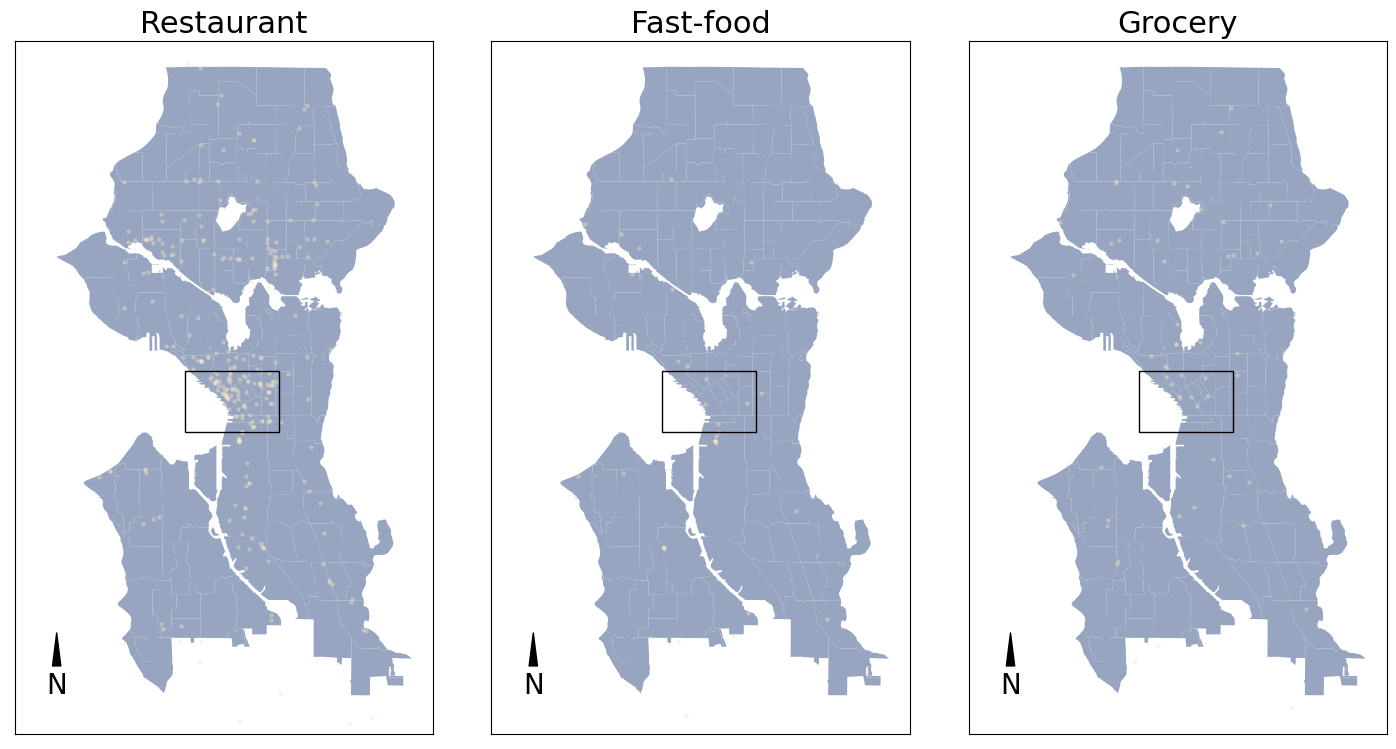

In [82]:
# Define the coordinates of the bounding box
x_min, x_max = -122.363604, -122.310561
y_min, y_max = 47.595458, 47.618721

fig, axs = plt.subplots(1, 3, figsize=(20,9))

poi_types_dfs = [restaurants, quick_service, grocery]
sub_titles = ["Restaurant", "Fast-food", "Grocery"]
count = 0
fig.subplots_adjust(wspace=-0.2) # adjust the spacing

for j in range(len(poi_types_dfs)):
    # plot base map
    tracts_2010_updated.to_crs(epsg=4326).plot(ax = axs[j], color = '#97A5C0')
    # plot poi locations by type
    poi_types_dfs[count].plot(ax=axs[j], alpha=0.3, markersize = 5, color = '#F4E8C0')

    # remove the x and y ticks, set titles for subplots
    axs[j].set_xticks([], [])
    axs[j].set_yticks([], [])
    axs[j].set_xlim(-122.459444, -122.224167) # Set the x-axis limits
    axs[j].set_ylim(47.480833, 47.743889) # Set the y-axis limits
    axs[j].set_title(sub_titles[count], fontsize=22)
    count += 1

# Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='black', facecolor='none')

# Add the patch to the axes
    axs[j].add_patch(rect)
    # add north arrow
    axs[j].annotate('N', xy=(0.1, 0.15), xytext=(0.1, 0.05), ha='center', va='bottom',
                    xycoords='axes fraction', textcoords='axes fraction', fontsize=20,
                    arrowprops=dict(facecolor='black', arrowstyle='wedge'))


# plt.savefig(input_path + "upscaled_rj/figures_remade" + "/outlet_distribution.png", bbox_inches='tight')
plt.show()

In [103]:
import geopandas as gpd

merged_tracts = gpd.GeoDataFrame(merged_tracts, geometry='geometry_x')


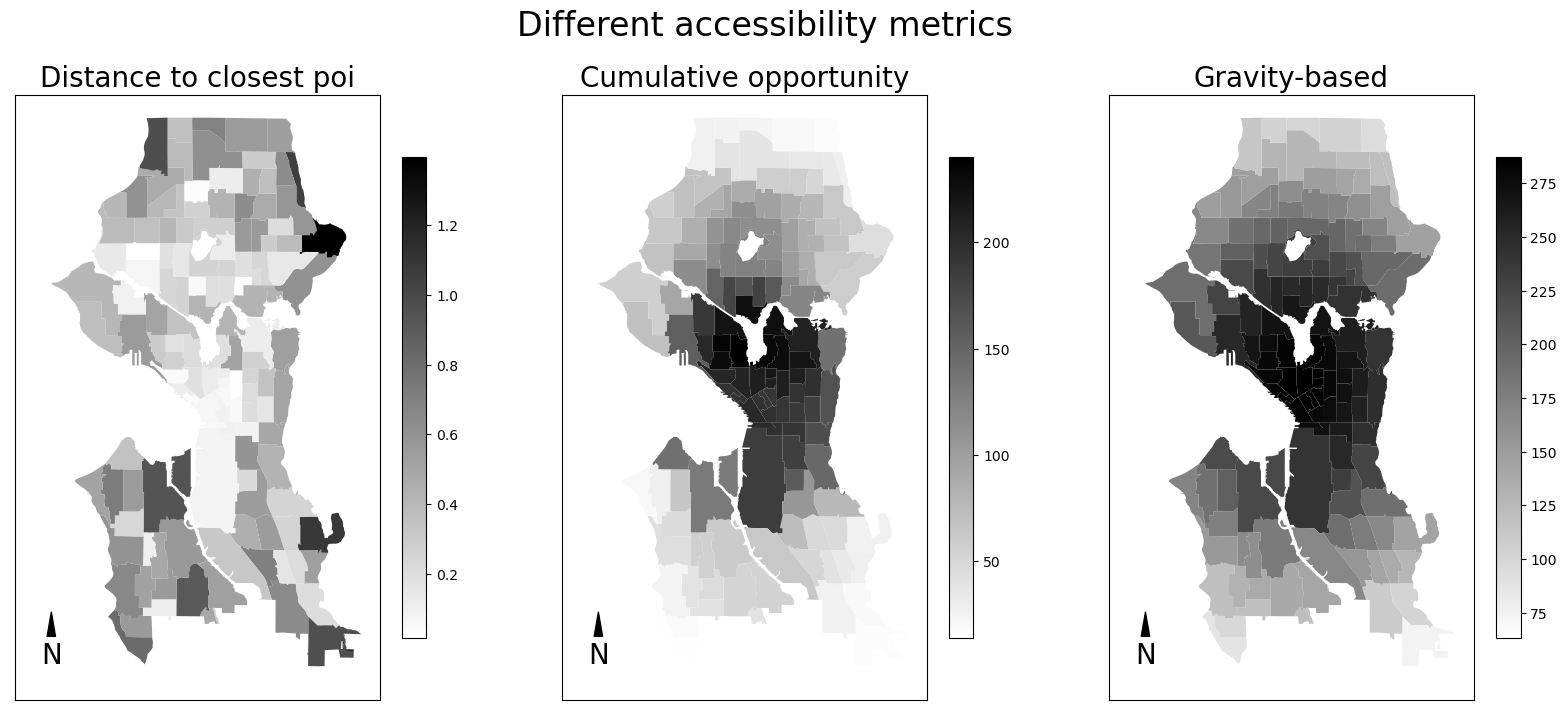

In [104]:
columns_to_plot = ['distance_to_closest_poi', 'Cumu_opp', 'gravity_acc']
sub_titles = ["Distance to closest poi", "Cumulative opportunity", "Gravity-based"]
count = 0

cmap = plt.cm.get_cmap('binary')

fig, axs = plt.subplots(1, 3, figsize=(20,8))

for j in range(3):
    merged_tracts.to_crs(epsg=4326).plot(column=columns_to_plot[count], ax=axs[j], cmap=cmap, legend=True, legend_kwds={'shrink': 0.78})

    axs[j].set_xticks([])
    axs[j].set_yticks([])
    axs[j].set_xlim(-122.459444, -122.224167) 
    axs[j].set_ylim(47.480833, 47.743889) 
    axs[j].set_title(sub_titles[count], fontsize=20)
    count += 1
    
    axs[j].annotate('N', xy=(0.1, 0.15), xytext=(0.1, 0.05), ha='center', va='bottom',
                    xycoords='axes fraction', textcoords='axes fraction', fontsize=20,
                    arrowprops=dict(facecolor='black', arrowstyle='wedge'))

# fig.tight_layout(pad=3.0)
plt.suptitle('Different accessibility metrics', fontsize=24)
# plt.savefig("Metrics_comparison.png", bbox_inches='tight')
plt.show()

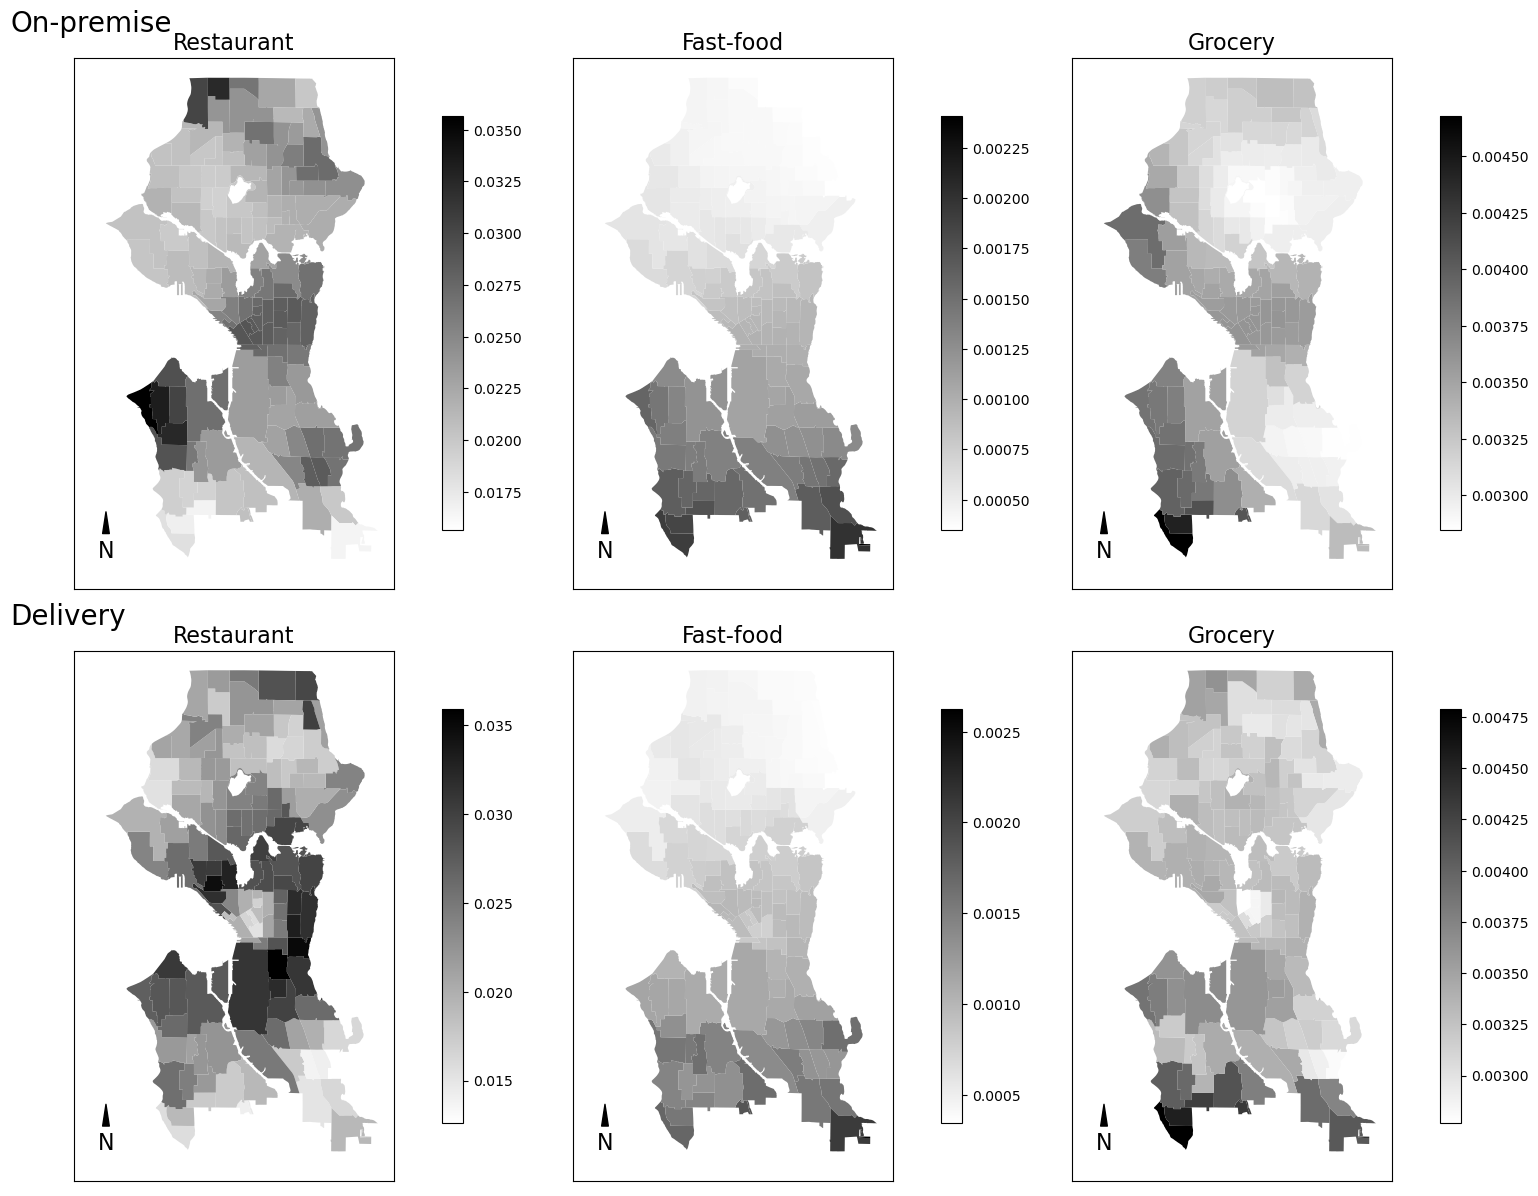

In [105]:

columns_to_plot_dine_in = ["Food Accessibility without Delivery restaurant",
                           "Food Accessibility without Delivery quick service",
                           "Food Accessibility without Delivery grocery",
                           "Food Accessibility without Delivery others"]

columns_to_plot_delivery = ["Food Accessibility with only Delivery restaurant",
                            "Food Accessibility with only Delivery quick service",
                            "Food Accessibility with only Delivery grocery",
                            "Food Accessibility with only Delivery others"]

poi_types_dfs = [restaurants, quick_service, grocery, other]
sub_titles = ["Restaurant", "Fast-food", "Grocery", "Others"]
cmap = 'binary'
row_annotation = ['On-premise', 'Delivery']
# cmap = plt.cm.get_cmap('binary')

fig, axs = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(wspace=-0.6, hspace=0.3)
# Adjust spacing


for i in range(2):  # Loop for the rows
    count = 0
    for j in range(3):  # Loop for the columns
        if i == 0:
            columns_to_plot = columns_to_plot_dine_in
        else:
            columns_to_plot = columns_to_plot_delivery

        merged_tracts.to_crs(epsg=4326).plot(column=columns_to_plot[count], ax=axs[i, j], cmap=cmap, legend=True, legend_kwds={'shrink': 0.78})

        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlim(-122.459444, -122.224167)
        axs[i, j].set_ylim(47.480833, 47.743889)
        axs[i, j].set_title(sub_titles[count], fontsize=16)
        count += 1

        axs[i, j].annotate('N', xy=(0.1, 0.15), xytext=(0.1, 0.05), ha='center', va='bottom',
                           xycoords='axes fraction', textcoords='axes fraction', fontsize=16,
                           arrowprops=dict(facecolor='black', arrowstyle='wedge'))

# Add row annotations
axs[0, 0].annotate(row_annotation[0], xy=(-0.2, 1.05), xycoords='axes fraction', fontsize=20)
axs[1, 0].annotate(row_annotation[1], xy=(-0.2, 1.05), xycoords='axes fraction', fontsize=20)
fig.tight_layout()
# Add a title
# plt.suptitle('Categoric specific food accessibility', fontsize=24)
# plt.savefig("/A_ic_heatmap.png", bbox_inches='tight')
plt.show()